### Importação de bibliotecas e carregamento do dataset

Nesta célula, são importadas as bibliotecas necessárias para o pré-processamento, visualização e modelagem dos dados. Em seguida, é feito o carregamento do dataset **"Estimation of obesity levels based on eating habits and physical condition"** da UCI Machine Learning Repository utilizando a função `fetch_ucirepo`.

- `fetch_ucirepo`: permite acessar datasets da UCI de forma prática.
- `sklearn.cluster.KMeans`: será utilizado posteriormente para realizar a clusterização.
- `PCA` e `matplotlib.pyplot`: serão usados para reduzir a dimensionalidade dos dados e visualizá-los em plots.
- O objeto retornado é dividido em `X` (features) e `y` (targets), contendo, respectivamente, os atributos e os rótulos de classificação de obesidade.


In [28]:
from ucimlrepo import fetch_ucirepo 
from sklearn.cluster import KMeans
import numpy as np
from features.columns import CompositeTranformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# fetch dataset 
estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition = fetch_ucirepo(id=544) 
X = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.features
y = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.targets 


In [29]:
print(X)
print(y)

      Gender        Age    Height      Weight family_history_with_overweight  \
0     Female  21.000000  1.620000   64.000000                            yes   
1     Female  21.000000  1.520000   56.000000                            yes   
2       Male  23.000000  1.800000   77.000000                            yes   
3       Male  27.000000  1.800000   87.000000                             no   
4       Male  22.000000  1.780000   89.800000                             no   
...      ...        ...       ...         ...                            ...   
2106  Female  20.976842  1.710730  131.408528                            yes   
2107  Female  21.982942  1.748584  133.742943                            yes   
2108  Female  22.524036  1.752206  133.689352                            yes   
2109  Female  24.361936  1.739450  133.346641                            yes   
2110  Female  23.664709  1.738836  133.472641                            yes   

     FAVC  FCVC  NCP       CAEC SMOKE  

### Pré-processamento dos dados

Nesta célula, é realizado o pré-processamento dos dados, separando as colunas categóricas e numéricas e aplicando transformações a cada tipo.

- `columns_cat`: define as colunas com variáveis categóricas.
- `columns_num`: define as colunas com variáveis numéricas, excluindo as categóricas e a variável alvo (`NObeyesdad`).

Um transformador composto (`CompositeTranformer`) é utilizado para aplicar o pré-processamento necessário:
- Para `X`, são transformadas separadamente as colunas numéricas e categóricas, ao qual utilizamos MinMaxScaler e one hot encoder, respectivamente.
- Para `y`, é aplicada uma transformação categórica na variável alvo (`NObeyesdad`) para convertê-la em valores numéricos, ou seja, apenas one hot encoder.

O resultado são os dados prontos para serem utilizados no algoritmo do k-mean.

In [30]:

columns_cat = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC' , 'CALC', 'MTRANS']
columns_num = X.columns.difference(columns_cat).difference(['NObeyesdad'])


tranformer_x = CompositeTranformer( numeric_features=columns_num, categorical_features=columns_cat)

X_transformed = tranformer_x.transform(X)


transformer_y = CompositeTranformer(numeric_features=[], categorical_features=['NObeyesdad'])
y_transformed = transformer_y.transform(y)



### Captura das colunas de X e y após a transformação

- **X (features):**  
  As variáveis categóricas de `X` (como `Gender`, `SMOKE`, etc.) são transformadas usando o `OneHotEncoder`. Após a transformação, cada categoria de uma variável pode gerar várias colunas. Por exemplo, se a variável `Gender` possui duas categorias (masculino e feminino), ela será transformada em duas colunas, representando cada uma das categorias.

- **y (target):**  
  A variável categórica `NObeyesdad` de `y` é transformada da mesma maneira, criando várias colunas para cada categoria presente na variável. Por exemplo, como `NObeyesdad` tem 7 categorias (insufficiente weight, normal weight...), ela será transformada em 7 colunas.

- **Objetivo:**  
  Combinar as colunas numéricas originais de `X` com as novas colunas geradas pela transformação das variáveis categóricas.


In [31]:

encoder_x = tranformer_x.encoder.transformers_[1][1].encoder 
encoder_x.fit(X[columns_cat])
categorical_feature_names_x = encoder_x.get_feature_names_out()
X_columns_transformed = list(columns_num) + list(categorical_feature_names_x)

encoder_y = transformer_y.encoder.transformers_[1][1].encoder  
encoder_y.fit(y)
categorical_feature_names_y = encoder_y.get_feature_names_out()
y_columns_transformed = list(categorical_feature_names_y)

# Imprimindo os nomes das colunas transformadas
print(X_columns_transformed)
print(y_columns_transformed)


['Age', 'CH2O', 'FAF', 'FCVC', 'Height', 'NCP', 'TUE', 'Weight', 'Gender_Female', 'Gender_Male', 'family_history_with_overweight_no', 'family_history_with_overweight_yes', 'FAVC_no', 'FAVC_yes', 'CAEC_Always', 'CAEC_Frequently', 'CAEC_Sometimes', 'CAEC_no', 'SMOKE_no', 'SMOKE_yes', 'SCC_no', 'SCC_yes', 'CALC_Always', 'CALC_Frequently', 'CALC_Sometimes', 'CALC_no', 'MTRANS_Automobile', 'MTRANS_Bike', 'MTRANS_Motorbike', 'MTRANS_Public_Transportation', 'MTRANS_Walking']
['NObeyesdad_Insufficient_Weight', 'NObeyesdad_Normal_Weight', 'NObeyesdad_Obesity_Type_I', 'NObeyesdad_Obesity_Type_II', 'NObeyesdad_Obesity_Type_III', 'NObeyesdad_Overweight_Level_I', 'NObeyesdad_Overweight_Level_II']


### Geração e Salvamento do Heatmap de Correlação

- **Objetivo:**  
  O código cria um heatmap de correlação entre as variáveis transformadas de `X` e `y`, utilizando o coeficiente de correlação de Spearman. O gráfico ajuda a visualizar as relações entre as variáveis.

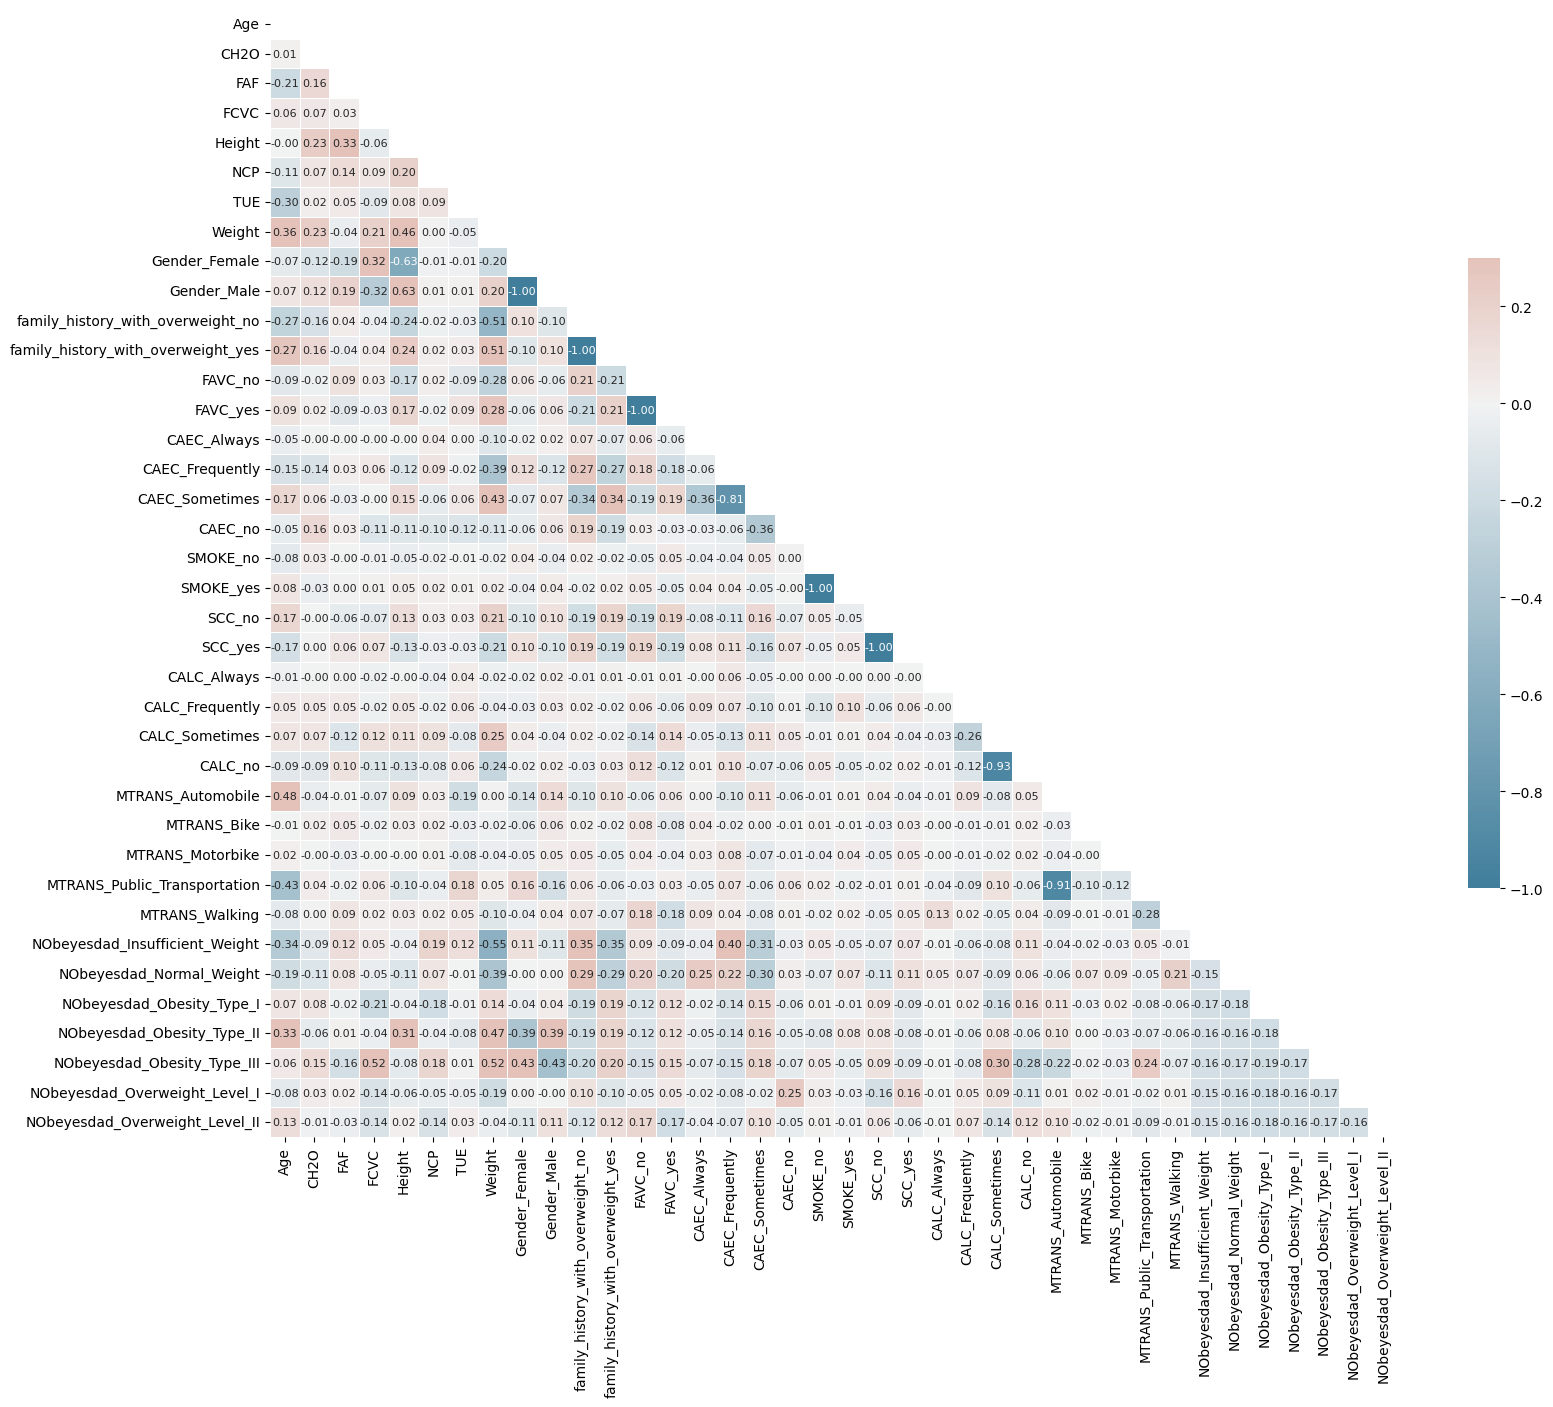

In [32]:
import pandas as pd
import seaborn as sns
import os
import pandas as pd


if not os.path.exists('results'):
    os.makedirs('results')

X_df = pd.DataFrame(X_transformed, columns = X_columns_transformed)
y_df = pd.DataFrame(y_transformed, columns = y_columns_transformed)

data = pd.concat([X_df, y_df], axis=1)

corr = data.corr(method='spearman')

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(17, 15))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

heatmap = sns.heatmap(
    corr, 
    mask=mask, 
    cmap=cmap, 
    vmax=0.3, 
    center=0,
    square=True, 
    linewidths=0.5, 
    cbar_kws={"shrink": 0.5},  
    annot=True,  
    fmt=".2f",   
    annot_kws={"size": 8},  
    xticklabels=corr.columns,  
    yticklabels=corr.columns  
)

heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=10)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=10)

plt.tight_layout()
plt.savefig('results/heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

### Aplicação do algoritmo K-Means

Nesta célula, é aplicado o algoritmo de clusterização **K-Means** com os seguintes parâmetros:

- `n_clusters=7`: define que o número de clusters (grupos) a ser formado é 7.
- `random_state=0`: garante a reprodutibilidade dos resultados.
- `n_init="auto"`: utiliza o número adequado de inicializações para garantir uma boa solução.

O método `fit()` treina o modelo com os dados de entrada `X`, e o atributo `labels_` retorna os rótulos dos clusters atribuídos a cada amostra do conjunto de dados. Ou seja, se na primeira posição retornar o valor 1, significa que o paciente pertence ao grupo 1.


In [33]:
kmeans = KMeans(n_clusters=7, random_state=0, n_init="auto")
kmeans.fit(X_transformed)
kmeans.labels_

array([1, 5, 6, ..., 3, 3, 3], shape=(2111,), dtype=int32)

### Método do Cotovelo com Intervalo de Confiança

Esta célula implementa o **método do cotovelo** para ajudar na escolha do número ideal de clusters (k) no algoritmo K-Means, incorporando **intervalos de confiança** para tornar a análise mais robusta.

#### Etapas principais:

- **Importações**: São carregadas bibliotecas para clustering, visualização e cálculo estatístico.
- **Loop para múltiplas execuções**: Para cada valor de `k` (de 1 a 50), o K-Means é executado 30 vezes. As inércias (soma das distâncias quadradas dentro dos clusters) são armazenadas.
- **Intervalos de confiança**: Para cada `k`, é calculado o intervalo de confiança da inércia usando a classe `ConfidenceInterval` com um nível de 95% (`alpha = 0.05`), com o cálculo do bootstrap nessa classe.
- **Execução única**: Para comparação, também é feita uma única execução do K-Means com `random_state=0` para cada valor de `k`.

#### Visualizações:

- **Gráfico à esquerda**: Mostra a inércia média por valor de `k`, com a faixa do intervalo de confiança.
- **Gráfico à direita**: Mostra as inércias obtidas em uma única execução para cada `k`.

Esse método ajuda a visualizar o ponto de inflexão ("cotovelo") , que sugere o número ideal de clusters.


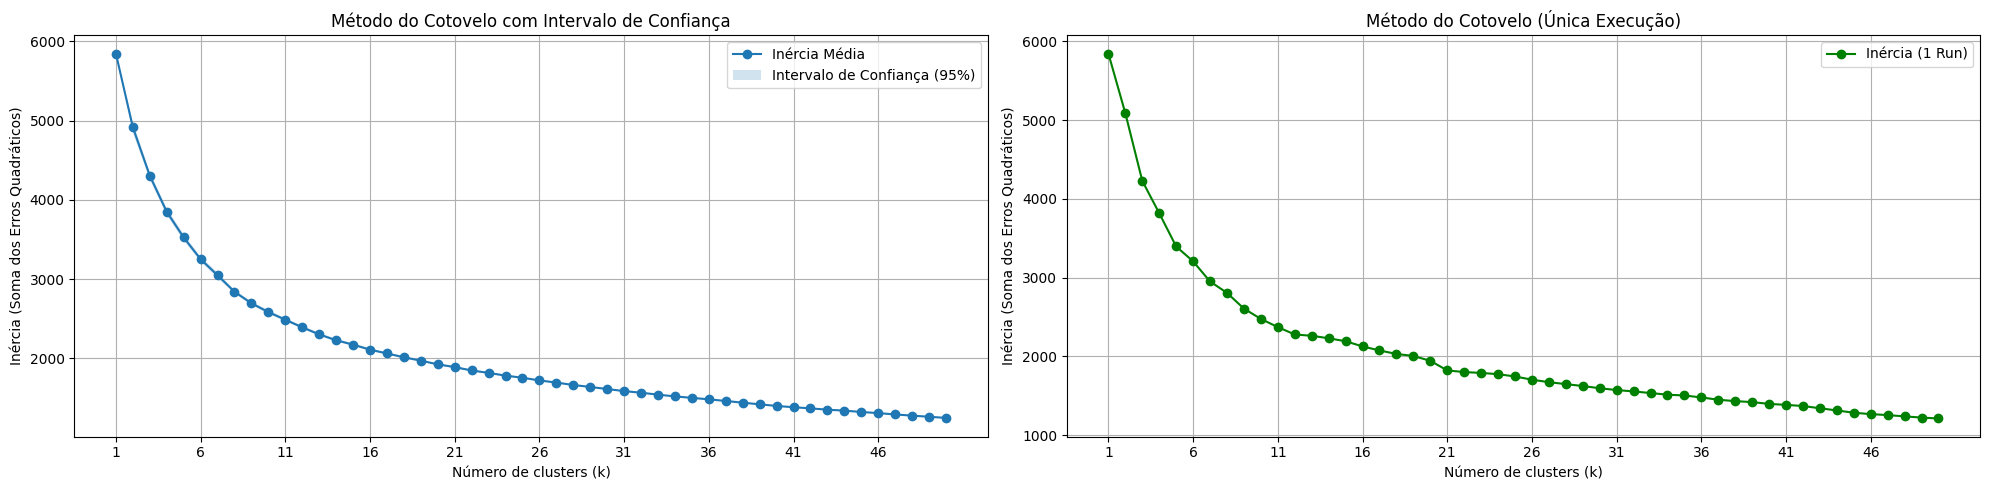

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import norm
from utils.confidence_interval import ConfidenceInterval

K_range = range(1, 51)
n_runs = 30 
alpha = 0.05 # alpha para o intervalo de confiança

all_inertias = np.zeros((len(K_range), n_runs)) 

for i, k in enumerate(K_range):
    for run in range(n_runs):
        kmeans = KMeans(n_clusters=k, n_init="auto", random_state=run)
        kmeans.fit(X_transformed) 
        all_inertias[i, run] = kmeans.inertia_

means = []
lower_bounds = []
upper_bounds = []

# o bootstrap está sendo calculado dentro da classe confidence interval
for i, k in enumerate(K_range):
    ci = ConfidenceInterval(all_inertias[i, :], alpha)  
    means.append(ci.mean)
    lower_bounds.append(ci.calculate_lower_bound())
    upper_bounds.append(ci.calculate_upper_bound())

single_run_inertias = []
for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init="auto", random_state=0)
    kmeans.fit(X_transformed) 
    single_run_inertias.append(kmeans.inertia_)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.plot(K_range, means, marker='o', label='Inércia Média')
ax1.fill_between(K_range, lower_bounds, upper_bounds, alpha=0.2, label='Intervalo de Confiança (95%)')
ax1.set_xlabel('Número de clusters (k)')
ax1.set_ylabel('Inércia (Soma dos Erros Quadráticos)')
ax1.set_title('Método do Cotovelo com Intervalo de Confiança')
ax1.set_xticks(list(K_range)[::5]) 
ax1.grid(True)
ax1.legend()

ax2.plot(K_range, single_run_inertias, marker='o', color='green', label='Inércia (1 Run)')
ax2.set_xlabel('Número de clusters (k)')
ax2.set_ylabel('Inércia (Soma dos Erros Quadráticos)')
ax2.set_title('Método do Cotovelo (Única Execução)')
ax2.set_xticks(list(K_range)[::5])  
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.savefig('results/cotovelo.png', dpi=300, bbox_inches='tight')

plt.show()